# PixelCNN

**Author:** [ADMoreau](https://github.com/ADMoreau)<br>
**Date created:** 2020/05/17<br>
**Last modified:** 2020/05/23<br>
**Description:** PixelCNN implemented in Keras.<br>
**Translate:** [Junghyun Park](https://github.com/parkjh688)

## 시작하기

PixeCNN은 2016년 van den Oord이 제안한 생성모델 입니다.(reference: [Conditional Image Generation with PixelCNN Decoders](https://arxiv.org/abs/1606.05328)).
이 모델은 이전 요소의 확률 분포가 이후 요소의 확률 분포를 나타내는 입력 벡터에서 반복적으로 이미지(또는 다른 데이터 타입)를 생성하도록 설계되었습니다. 다음 예에서 이미지는 이전에 생성된 픽셀(왼쪽 위)의 데이터만 보고 이후 픽셀을 생성하는 마스킹된 컨볼루션 커널을 통해 픽셀 단위로 생성됩니다. 추론하는 동안, 네트워크의 출력은 새로운 픽셀 값을 샘플링하여 새 영상을 생성하는 확률 분포로 사용됩니다(여기서 MNIST에서는 픽셀 값이 흰색(0)에서 검은색(255).

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## 데이터 가져오기


In [3]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)
n_residual_blocks = 5

# 데이터는 트레인, 테스트 셋으로 분리
# 보통은 아래와 같이 사용
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
(x, _), (y, _) = keras.datasets.mnist.load_data()

# 모든 이미지를 합칩니다.
data = np.concatenate((x, y), axis=0)

# 모든 픽셀 값이 최대 256의 33% 미만일 경우 0으로 설정
# 이 값을 초과하는 모든 값은 1로 설정.
# 모든 값이 0 또는 1
data = np.where(data < (0.33 * 256), 0, 1)
data = data.astype(np.float32)


11493376/11490434 [==============================] - 0s 0us/step


In [4]:
data[0].shape

(28, 28)

## 모델에 필요한 레이어에 클래스 두 개 만들기


In [5]:
# 첫 번째 레이어는 PixelCNN 레이어 입니다. 이 레이어는 간단히
# 2D 컨볼루셔널 레이어로 만들어지지만, 마스킹을 포함합니다.
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(PixelConvLayer, self).__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # 커널 변수를 초기화하기 위한 conv2d 레이어 만들기 
        self.conv.build(input_shape)
        # 마스크를 만들기 위해 초기화된 커널 사용 
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)


In [6]:
# 다음은, 레지듀얼 블록 레이어를 만듭니다.
# 이것은 평범한 레지듀얼 블록이지만, PixelConvLayer에 기반합니다.
class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return keras.layers.add([inputs, x])


## 논문에 기반한 모델 만들기


In [9]:
inputs = keras.Input(shape=input_shape)
x = PixelConvLayer(
    mask_type="A", filters=128, kernel_size=7, activation="relu", padding="same"
)(inputs)

for _ in range(n_residual_blocks):
    x = ResidualBlock(filters=128)(x)

for _ in range(2):
    x = PixelConvLayer(
        mask_type="B",
        filters=128,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = keras.layers.Conv2D(
    filters=1, kernel_size=1, strides=1, activation="sigmoid", padding="valid"
)(x)

pixel_cnn = keras.Model(inputs, out)
adam = keras.optimizers.Adam(learning_rate=0.0005)
with tf.device('/gpu:0'):
  pixel_cnn.compile(optimizer=adam, loss="binary_crossentropy")
  pixel_cnn.summary()         #ACTUAL EPOCHS IS 50
  pixel_cnn.fit(
      x=data, y=data, batch_size=128, epochs=5, validation_split=0.1, verbose=1
  )


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
pixel_conv_layer_16 (PixelCo (None, 28, 28, 128)       6400      
_________________________________________________________________
residual_block_10 (ResidualB (None, 28, 28, 128)       98624     
_________________________________________________________________
residual_block_11 (ResidualB (None, 28, 28, 128)       98624     
_________________________________________________________________
residual_block_12 (ResidualB (None, 28, 28, 128)       98624     
_________________________________________________________________
residual_block_13 (ResidualB (None, 28, 28, 128)       98624     
_________________________________________________________________
residual_block_14 (ResidualB (None, 28, 28, 128)       9862

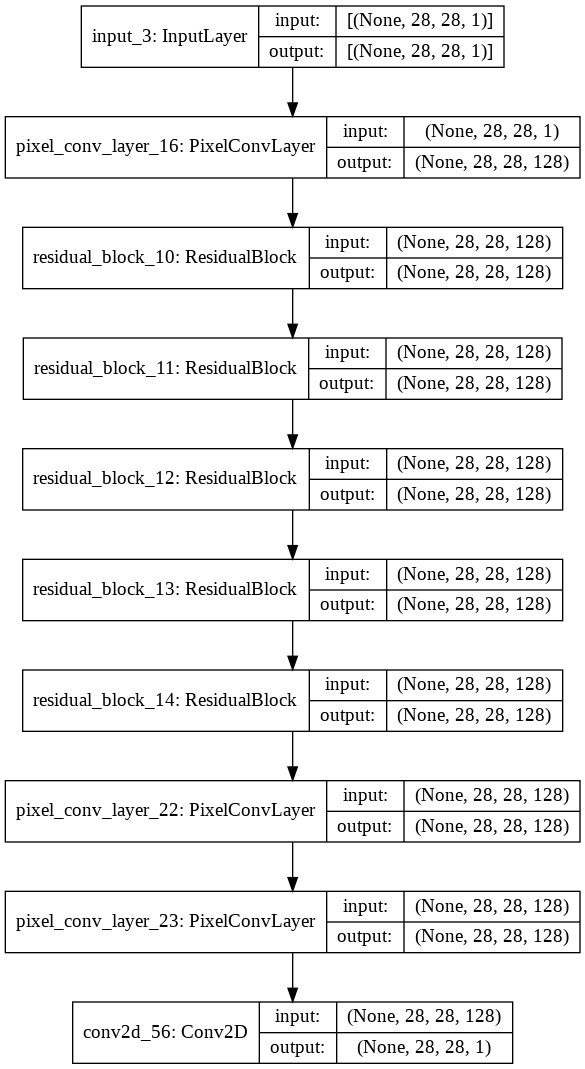

In [10]:
from keras.utils.vis_utils import plot_model
plot_model(pixel_cnn, show_shapes=True, show_layer_names=True)

## 해보기

PixelCNN은 이미지 전체를 한 번에 생성하지 못합니다. 대신 각 픽셀을 순서대로 생성하고 마지막으로 생성된 픽셀을 현재 이미지 추가한 다음, 이미지를 다시 모델에 공급하여 프로세스를 반복해야 합니다.


In [11]:
from IPython.display import Image, display

# Create an empty array of pixels.
# 픽셀의 빈 배열 만들기
batch = 4
pixels = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols, channels = pixels.shape

# Iterate over the pixels because generation has to be done sequentially pixel by pixel.
# 생성은 픽셀 단위로 순차적으로 수행되기 때문에 픽셀에 대해 반복됩니다.
for row in tqdm(range(rows)):
    for col in range(cols):
        for channel in range(channels):
            # 전체 배열 피딩하고(feed) 다음 픽셀에 대한 픽셀 값 확률 탐지. 
            probs = pixel_cnn.predict(pixels)[:, row, col, channel]
            # 확률을 사용하여 픽셀 값을 선택하고, 선택한 값을 이미지 프레임에 추가
            pixels[:, row, col, channel] = tf.math.ceil(
                probs - tf.random.uniform(probs.shape)
            )


def deprocess_image(x):
    # 단일 채널화된 흑백 이미지를 RGB 값으로 쌓습니다(stack).
    x = np.stack((x, x, x), 2)
    # 전처리 돌려놓기
    x *= 255.0
    # uint8로 변환하고 유효한 범위인 [0, 255]로 클립합니다 
    x = np.clip(x, 0, 255).astype("uint8")
    return x


# 생성 된 이미지를 반복하고 matplotlib로 플로팅합니다.
for i, pic in enumerate(pixels):
    keras.preprocessing.image.save_img(
        "generated_image_{}.png".format(i), deprocess_image(np.squeeze(pic, -1))
    )

display(Image("generated_image_0.png"))
display(Image("generated_image_1.png"))
display(Image("generated_image_2.png"))
display(Image("generated_image_3.png"))


100%|██████████| 28/28 [00:39<00:00,  1.42s/it]
